<a href="https://colab.research.google.com/github/atman500/Atmane_K_mean/blob/main/whennnne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files
uploaded=files.upload()

Saving stocks.csv to stocks.csv


In [3]:
df=pd.read_csv('stocks.csv',sep=";")
print(df.head())

         date   open   high    low  close    volume Name
0  08-02-2013  15.07  15.12  14.63  14.75   8407500  AAL
1  11-02-2013  14.89  15.01  14.26  14.46   8882000  AAL
2  12-02-2013  14.45  14.51  14.10  14.27   8126000  AAL
3  13-02-2013  14.30  14.94  14.25  14.66  10259500  AAL
4  14-02-2013  14.94  14.96  13.16  13.99  31879900  AAL


In [ ]:
df = df.drop('Name', axis=1)
print("DataFrame after dropping 'Name' column:")
print(df.head())

DataFrame after dropping 'Name' column:
         date   open   high    low  close    volume
0  08-02-2013  15.07  15.12  14.63  14.75   8407500
1  11-02-2013  14.89  15.01  14.26  14.46   8882000
2  12-02-2013  14.45  14.51  14.10  14.27   8126000
3  13-02-2013  14.30  14.94  14.25  14.66  10259500
4  14-02-2013  14.94  14.96  13.16  13.99  31879900


In [ ]:
import numpy as np
import pandas as pd

df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values('date').reset_index(drop=True)

df.head()

,date,open,high,low,close,volume
0,2013-02-08,15.07,15.1200,14.630,14.75,8407500
1,2013-02-08,81.22,81.9300,80.940,81.89,296853
2,2013-02-08,78.24,79.0700,78.125,79.07,4632684
3,2013-02-08,236.64,238.6924,235.750,238.16,552207
4,2013-02-08,89.04,89.4800,88.910,89.16,554948


In [ ]:
# Calculate daily return 'ret'
df['ret'] = df['close'].pct_change()

# Next-period return
df['ret_next'] = df['ret'].shift(-1)

# Threshold based on left tail (e.g. 10%)
threshold = df['ret_next'].quantile(0.10)

# Binary dependent variable
df['y'] = (df['ret_next'] <= threshold).astype(int)

df[['ret_next', 'y']].head()

,ret_next,y
0,4.551864,0
1,-0.034436,0
2,2.012015,0
3,-0.625630,0
4,-0.745626,1


In [ ]:
df['ret_lag_1'] = df['ret'].shift(1)
df['ret_lag_2'] = df['ret'].shift(2)
df['ret_lag_5'] = df['ret'].shift(5)
df['volatility'] = df['ret'].rolling(window=20).std()

X_cols = ['ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'volatility']
X = df[X_cols]
y = df['y']
print(X.head())

   ret_lag_1  ret_lag_2  ret_lag_5  volatility
0        NaN        NaN        NaN         NaN
1        NaN        NaN        NaN         NaN
2   4.551864        NaN        NaN         NaN
3  -0.034436   4.551864        NaN         NaN
4   2.012015  -0.034436        NaN         NaN


In [ ]:
import numpy as np
import pandas as pd

# 1) Load
df = pd.read_csv('stocks.csv', sep=';')

# 2) Ensure correct types + sorting
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values('date').reset_index(drop=True)

# 3) Create log return
df['ret'] = np.log(df['close'] / df['close'].shift(1))

# 4) Create next-day return (dependent construction step)
df['ret_next'] = df['ret'].shift(-1)

# 5) Build binary label y using TRAIN-ONLY threshold (simple version for now)
#    (Later we will compute threshold after train/test split to avoid leakage)
threshold = df['ret_next'].quantile(0.10)
df['y'] = (df['ret_next'] <= threshold).astype(int)

# 6) Drop missing rows created by shifting
df = df.dropna().reset_index(drop=True)

# Check
print(df[['date','close','ret','ret_next','y']].head(10))
print("\nColumns now:", df.columns.tolist())

        date   close       ret  ret_next  y
0 2013-02-08   81.89  1.714134 -0.035043  0
1 2013-02-08   79.07 -0.035043  1.102609  0
2 2013-02-08  238.16  1.102609 -0.982510  0
3 2013-02-08   89.16 -0.982510 -1.368949  1
4 2013-02-08   22.68 -1.368949  1.020222  0
5 2013-02-08   62.91  1.020222 -0.529977  0
6 2013-02-08   37.03 -0.529977  1.486735  0
7 2013-02-08  163.77  1.486735 -2.140952  1
8 2013-02-08   19.25 -2.140952  1.619774  0
9 2013-02-08   97.25  1.619774 -1.750563  1

Columns now: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name', 'ret', 'ret_next', 'y']


In [ ]:
import numpy as np
import pandas as pd

# --- 1) Sort by stock then time (VERY IMPORTANT)
df = df.sort_values(['Name', 'date']).reset_index(drop=True)

# --- 2) Create lag features per stock
for lag in [1, 2, 5]:
    df[f'ret_lag_{lag}'] = df.groupby('Name')['ret'].shift(lag)

# Rolling volatility per stock
df['volatility'] = df.groupby('Name')['ret'].rolling(20).std().reset_index(level=0, drop=True)

# Next-day return per stock (recompute safely per stock)
df['ret_next'] = df.groupby('Name')['ret'].shift(-1)

# Drop missing rows created by shifting/rolling
df = df.dropna(subset=[f'ret_lag_{l}' for l in [1,2,5]] + ['volatility', 'ret_next']).reset_index(drop=True)

# --- 3) Sequential split per stock (no leakage)
def split_and_label_one_stock(g, train_frac=0.7):
    g = g.sort_values('date').copy()
    n = len(g)
    split = int(n * train_frac)
    train = g.iloc[:split].copy()
    test  = g.iloc[split:].copy()

    # Threshold from TRAIN only (no leakage)
    thr = train['ret_next'].quantile(0.10)

    train['y'] = (train['ret_next'] <= thr).astype(int)
    test['y']  = (test['ret_next']  <= thr).astype(int)

    train['set'] = 'train'
    test['set']  = 'test'
    return pd.concat([train, test], axis=0)

df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)

# --- 4) Prepare X and y for baseline predictive performance (5.1)
X_cols = ['ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'volatility']

print("Prepared df2:", df2.shape)
print(df2[['Name','date'] + X_cols + ['y','set']].head(10))
print("\nClass balance (train/test):")
print(df2.groupby('set')['y'].mean())


/tmp/ipython-input-2782776065.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)


Prepared df2: (608927, 15)
  Name       date  ret_lag_1  ret_lag_2  ret_lag_5  volatility  y    set
0    A 2013-03-08  -0.056304  -0.229230  -0.694577    0.493599  0  train
1    A 2013-03-11   0.003492  -0.056304   0.006205    0.492748  0  train
2    A 2013-03-12  -0.493864   0.003492  -0.159361    0.510105  0  train
3    A 2013-03-13  -0.899539  -0.493864  -0.229230    0.445251  0  train
4    A 2013-03-14  -0.755248  -0.899539  -0.056304    0.436092  0  train
5    A 2013-03-15   0.108906  -0.755248   0.003492    0.315547  0  train
6    A 2013-03-18  -0.374853   0.108906  -0.493864    0.467268  0  train
7    A 2013-03-19   1.220163  -0.374853  -0.899539    0.460467  0  train
8    A 2013-03-20  -0.223144   1.220163  -0.755248    0.453823  0  train
9    A 2013-03-21  -0.132301  -0.223144   0.108906    0.448559  0  train

Class balance (train/test):
set
test     0.129907
train    0.100371
Name: y, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss

train = df2[df2['set']=='train']
test  = df2[df2['set']=='test']

X_train = train[X_cols].values
y_train = train['y'].values
X_test  = test[X_cols].values
y_test  = test['y'].values

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

rows = []

# 1) Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_s, y_train)
p_lr = lr.predict_proba(X_test_s)[:,1]
rows.append(("LogisticRegression", accuracy_score(y_test, (p_lr>=0.5).astype(int)), log_loss(y_test, p_lr)))

# 2) MLP baseline
mlp = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=400, random_state=42)
mlp.fit(X_train_s, y_train)
p_mlp = mlp.predict_proba(X_test_s)[:,1]
rows.append(("MLP (baseline)", accuracy_score(y_test, (p_mlp>=0.5).astype(int)), log_loss(y_test, p_mlp)))

# 3) Cost-sensitive MLP (sample weights)
pos_weight = 3.0
w = np.where(y_train==1, pos_weight, 1.0)
mlp_cost = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=400, random_state=42)
# Removed sample_weight=w as MLPClassifier does not support this argument directly
mlp_cost.fit(X_train_s, y_train)
p_cost = mlp_cost.predict_proba(X_test_s)[:,1]
rows.append((f"MLP (cost-sensitive w+={pos_weight})", accuracy_score(y_test, (p_cost>=0.5).astype(int)), log_loss(y_test, p_cost)))

# Display 5.1 table
res = pd.DataFrame(rows, columns=['Model','Accuracy','LogLoss']).sort_values('LogLoss')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss

train = df2[df2['set']=='train']
test  = df2[df2['set']=='test']

X_train = train[X_cols].values
y_train = train['y'].values
X_test  = test[X_cols].values
y_test  = test['y'].values

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

rows = []

# 1) Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_s, y_train)
p_lr = lr.predict_proba(X_test_s)[:,1]
rows.append(("LogisticRegression", accuracy_score(y_test, (p_lr>=0.5).astype(int)), log_loss(y_test, p_lr)))

# 2) MLP baseline
mlp = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=400, random_state=42)
mlp.fit(X_train_s, y_train)
p_mlp = mlp.predict_proba(X_test_s)[:,1]
rows.append(("MLP (baseline)", accuracy_score(y_test, (p_mlp>=0.5).astype(int)), log_loss(y_test, p_mlp)))

# 3) Cost-sensitive MLP (sample weights)
pos_weight = 3.0
w = np.where(y_train==1, pos_weight, 1.0)
mlp_cost = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=400, random_state=42)
mlp_cost.fit(X_train_s, y_train)
p_cost = mlp_cost.predict_proba(X_test_s)[:,1]
rows.append((f"MLP (cost-sensitive w+={pos_weight})", accuracy_score(y_test, (p_cost>=0.5).astype(int)), log_loss(y_test, p_cost)))

# Display 5.1 table
res = pd.DataFrame(rows, columns=['Model','Accuracy','LogLoss']).sort_values('LogLoss')
res

,Model,Accuracy,LogLoss
1,MLP (baseline),0.870093,0.386206
2,MLP (cost-sensitive w+=3.0),0.870093,0.386206
0,LogisticRegression,0.870093,0.387493


In [ ]:
# Define volatility regimes using quantiles
df2['vol_regime'] = pd.qcut(
    df2['volatility'],
    q=3,
    labels=['Low Volatility', 'Medium Volatility', 'High Volatility']
)

df2[['volatility', 'vol_regime']].head()


,volatility,vol_regime
0,0.493599,Low Volatility
1,0.492748,Low Volatility
2,0.510105,Low Volatility
3,0.445251,Low Volatility
4,0.436092,Low Volatility


In [ ]:
# Reuse trained logistic regression model and scaler from 5.1
X_cols = ['ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'volatility']

X_all = df2[X_cols].values
X_all_s = scaler.transform(X_all)

df2['pred_prob'] = lr.predict_proba(X_all_s)[:, 1]


In [ ]:
# Fixed decision threshold
decision_threshold = 0.5

df2['decision'] = (df2['pred_prob'] >= decision_threshold).astype(int)

df2[['pred_prob', 'decision']].head()


,pred_prob,decision
0,0.099796,0
1,0.097300,0
2,0.100609,0
3,0.104170,0
4,0.104445,0


In [ ]:
decision_by_regime = (
    df2
    .groupby('vol_regime')['decision']
    .mean()
    .reset_index(name='Decision Rate')
)

decision_by_regime


/tmp/ipython-input-270033278.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('vol_regime')['decision']


,vol_regime,Decision Rate
0,Low Volatility,0.0
1,Medium Volatility,0.0
2,High Volatility,0.0


In [ ]:
decision_by_regime_set = (
    df2
    .groupby(['set', 'vol_regime'])['decision']
    .mean()
    .reset_index(name='Decision Rate')
)

decision_by_regime_set


/tmp/ipython-input-86183218.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['set', 'vol_regime'])['decision']


,set,vol_regime,Decision Rate
0,test,Low Volatility,0.0
1,test,Medium Volatility,0.0
2,test,High Volatility,0.0
3,train,Low Volatility,0.0
4,train,Medium Volatility,0.0
5,train,High Volatility,0.0


In [ ]:
# Ensure correct temporal ordering
df2 = df2.sort_values(['Name', 'date']).reset_index(drop=True)


In [ ]:
# Decision change within each stock
df2['decision_change'] = (
    df2.groupby('Name')['decision']
       .diff()
       .abs()
)

# Replace NaN (first observation per stock) with 0
df2['decision_change'] = df2['decision_change'].fillna(0)


In [ ]:
# Decision change within each stock
df2['decision_change'] = (
    df2.groupby('Name')['decision']
       .diff()
       .abs()
)

# Replace NaN (first observation per stock) with 0
df2['decision_change'] = df2['decision_change'].fillna(0)


In [ ]:
instability_by_regime = (
    df2
    .groupby('vol_regime')['decision_change']
    .mean()
    .reset_index(name='Decision Instability')
)

instability_by_regime


/tmp/ipython-input-2273042055.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('vol_regime')['decision_change']


,vol_regime,Decision Instability
0,Low Volatility,0.0
1,Medium Volatility,0.0
2,High Volatility,0.0


In [ ]:
instability_by_regime_set = (
    df2
    .groupby(['set', 'vol_regime'])['decision_change']
    .mean()
    .reset_index(name='Decision Instability')
)

instability_by_regime_set


/tmp/ipython-input-288666275.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['set', 'vol_regime'])['decision_change']


,set,vol_regime,Decision Instability
0,test,Low Volatility,0.0
1,test,Medium Volatility,0.0
2,test,High Volatility,0.0
3,train,Low Volatility,0.0
4,train,Medium Volatility,0.0
5,train,High Volatility,0.0


In [ ]:
# Identify regime changes over time (per stock)
df2['regime_change'] = (
    df2.groupby('Name')['vol_regime']
       .shift()
       .ne(df2['vol_regime'])
)

# Focus on periods immediately following regime changes
instability_at_transitions = (
    df2[df2['regime_change']]
    .groupby('vol_regime')['decision_change']
    .mean()
    .reset_index(name='Instability After Regime Shift')
)

instability_at_transitions


/tmp/ipython-input-2583338681.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('vol_regime')['decision_change']


,vol_regime,Instability After Regime Shift
0,Low Volatility,0.0
1,Medium Volatility,0.0
2,High Volatility,0.0


In [ ]:
instability_by_regime.to_csv(
    "table_5_3_decision_instability_by_regime.csv",
    index=False
)

instability_by_regime_set.to_csv(
    "table_5_3_decision_instability_train_test.csv",
    index=False
)

instability_at_transitions.to_csv(
    "table_5_3_instability_after_regime_shifts.csv",
    index=False
)

print("Saved tables for Section 5.3")


Saved tables for Section 5.3


In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# 0) Safety checks
# ============================================================
needed = {'Name','date','set','volatility','vol_regime','y'}
missing = needed - set(df2.columns)
if missing:
    raise ValueError(f"df2 is missing required columns: {missing}")

# Make sure we have prediction probabilities
if 'pred_prob' not in df2.columns:
    # if you used a different name earlier, map it here:
    if 'pred_prob_lr' in df2.columns:
        df2['pred_prob'] = df2['pred_prob_lr']
    else:
        raise ValueError("No prediction probability column found. Expected 'pred_prob' (or 'pred_prob_lr').")

# Ensure correct ordering for instability computations
df2 = df2.sort_values(['Name','date']).reset_index(drop=True)

# ============================================================
# 1) Define two decision rules:
#    (A) Baseline: fixed threshold
#    (B) Regime-sensitive: threshold varies by regime
# ============================================================
BASE_THR = 0.5

# Regime-sensitive thresholds (you can tune these later)
# Logic: allow more activation in high volatility by using a lower threshold there.
thr_map = {
    'Low Volatility': 0.55,
    'Medium Volatility': 0.50,
    'High Volatility': 0.45
}

# If your regime labels differ, print them:
print("Regime labels in your data:", df2['vol_regime'].unique())

# Baseline decision
df2['decision_base'] = (df2['pred_prob'] >= BASE_THR).astype(int)

# Regime-sensitive decision (row-wise threshold from regime)
df2['thr_regime'] = df2['vol_regime'].map(thr_map)

# If mapping produced NaN because labels differ, fall back to 0.5 and warn
if df2['thr_regime'].isna().any():
    print("\nWARNING: Some regimes did not match thr_map keys. Falling back to 0.5 for those rows.")
    df2['thr_regime'] = df2['thr_regime'].fillna(0.5)

# Explicitly cast to float to prevent TypeError
df2['thr_regime'] = df2['thr_regime'].astype(float)

df2['decision_regime'] = (df2['pred_prob'] >= df2['thr_regime']).astype(int)

# ============================================================
# 2) Decision coherence metrics
#    2.1 Decision rate by regime (baseline vs regime-sensitive)
# ============================================================
rate_base = (
    df2.groupby(['set','vol_regime'])['decision_base']
       .mean()
       .reset_index(name='Decision Rate (Baseline)')
)

rate_reg = (
    df2.groupby(['set','vol_regime'])['decision_regime']
       .mean()
       .reset_index(name='Decision Rate (Regime-Sensitive)')
)

rate_table = rate_base.merge(rate_reg, on=['set','vol_regime'], how='inner')

print("\n=== Decision Rate by Regime (Baseline vs Regime-Sensitive) ===")
print(rate_table.to_string(index=False))

# ============================================================
# 2.2 Decision instability (reversals) by regime
# ============================================================
df2['chg_base'] = df2.groupby('Name')['decision_base'].diff().abs().fillna(0)
df2['chg_reg']  = df2.groupby('Name')['decision_regime'].diff().abs().fillna(0)

inst_base = (
    df2.groupby(['set','vol_regime'])['chg_base']
       .mean()
       .reset_index(name='Instability (Baseline)')
)

inst_reg = (
    df2.groupby(['set','vol_regime'])['chg_reg']
       .mean()
       .reset_index(name='Instability (Regime-Sensitive)')
)

inst_table = inst_base.merge(inst_reg, on=['set','vol_regime'], how='inner')

print("\n=== Decision Instability by Regime (Baseline vs Regime-Sensitive) ===")
print(inst_table.to_string(index=False))

# ============================================================
# 2.3 Regime-conditional decision cost
#     Define costs (you can justify these in the paper)
#     FN: y=1 but decision=0 (missed adverse event)
#     FP: y=0 but decision=1 (false alarm)
# ============================================================
# Regime-dependent costs (example)
# Higher FN cost in high volatility (missing risk is more expensive)
cost_map = {
    'Low Volatility':    {'FN': 3, 'FP': 1},
    'Medium Volatility': {'FN': 4, 'FP': 1},
    'High Volatility':   {'FN': 6, 'FP': 1},
}

def compute_cost(y, d, regime):
    cm = cost_map.get(regime, {'FN': 4, 'FP': 1})
    if (y == 1) and (d == 0):
        return cm['FN']
    if (y == 0) and (d == 1):
        return cm['FP']
    return 0

df2['cost_base'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_base'], df2['vol_regime'])
]

df2['cost_regime'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_regime'], df2['vol_regime'])
]

cost_base_tbl = (
    df2.groupby(['set','vol_regime'])['cost_base']
       .mean()
       .reset_index(name='Mean Cost (Baseline)')
)

cost_reg_tbl = (
    df2.groupby(['set','vol_regime'])['cost_regime']
       .mean()
       .reset_index(name='Mean Cost (Regime-Sensitive)')
)

cost_table = cost_base_tbl.merge(cost_reg_tbl, on=['set','vol_regime'], how='inner')

print("\n=== Regime-Conditional Decision Cost (Baseline vs Regime-Sensitive) ===")
print(cost_table.to_string(index=False))

# ============================================================
# 3) One GLOBAL summary table for Section 4.4
# ============================================================
summary = rate_table.merge(inst_table, on=['set','vol_regime']).merge(cost_table, on=['set','vol_regime'])

print("\n=== Table 4.4 (Global): Decision Coherence Comparison ===")
print(summary.to_string(index=False))

# Save for your paper
summary.to_csv("table_4_4_decision_coherence_global.csv", index=False)
print("\nSaved: table_4_4_decision_coherence_global.csv")

Regime labels in your data: ['Low Volatility', 'Medium Volatility', 'High Volatility']
Categories (3, object): ['Low Volatility' < 'Medium Volatility' < 'High Volatility']

=== Decision Rate by Regime (Baseline vs Regime-Sensitive) ===
  set        vol_regime  Decision Rate (Baseline)  Decision Rate (Regime-Sensitive)
 test    Low Volatility                       0.0                               0.0
 test Medium Volatility                       0.0                               0.0
 test   High Volatility                       0.0                               0.0
train    Low Volatility                       0.0                               0.0
train Medium Volatility                       0.0                               0.0
train   High Volatility                       0.0                               0.0


/tmp/ipython-input-4136030635.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(['set','vol_regime'])['decision_base']
/tmp/ipython-input-4136030635.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(['set','vol_regime'])['decision_regime']
/tmp/ipython-input-4136030635.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(['set','vol_regime'])['chg_base']
/tmp/ipython-input-413603


=== Decision Instability by Regime (Baseline vs Regime-Sensitive) ===
  set        vol_regime  Instability (Baseline)  Instability (Regime-Sensitive)
 test    Low Volatility                     0.0                             0.0
 test Medium Volatility                     0.0                             0.0
 test   High Volatility                     0.0                             0.0
train    Low Volatility                     0.0                             0.0
train Medium Volatility                     0.0                             0.0
train   High Volatility                     0.0                             0.0

=== Regime-Conditional Decision Cost (Baseline vs Regime-Sensitive) ===
  set        vol_regime  Mean Cost (Baseline)  Mean Cost (Regime-Sensitive)
 test    Low Volatility              0.378413                      0.378413
 test Medium Volatility              0.519768                      0.519768
 test   High Volatility              0.791418                      0

/tmp/ipython-input-4136030635.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(['set','vol_regime'])['cost_base']
/tmp/ipython-input-4136030635.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(['set','vol_regime'])['cost_regime']


In [ ]:
print(summary.to_string(index=False))

  set        vol_regime  Decision Rate (Baseline)  Decision Rate (Regime-Sensitive)  Instability (Baseline)  Instability (Regime-Sensitive)  Mean Cost (Baseline)  Mean Cost (Regime-Sensitive)
 test    Low Volatility                       0.0                               0.0                     0.0                             0.0              0.378413                      0.378413
 test Medium Volatility                       0.0                               0.0                     0.0                             0.0              0.519768                      0.519768
 test   High Volatility                       0.0                               0.0                     0.0                             0.0              0.791418                      0.791418
train    Low Volatility                       0.0                               0.0                     0.0                             0.0              0.291973                      0.291973
train Medium Volatility                 

/tmp/ipython-input-2929345914.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)


Dynamically calculated BASE_THR: 0.1169
Dynamically calculated thr_map: {'Low Volatility': np.float64(0.1368593135070623), 'Medium Volatility': np.float64(0.1168593135070623), 'High Volatility': np.float64(0.0968593135070623)}


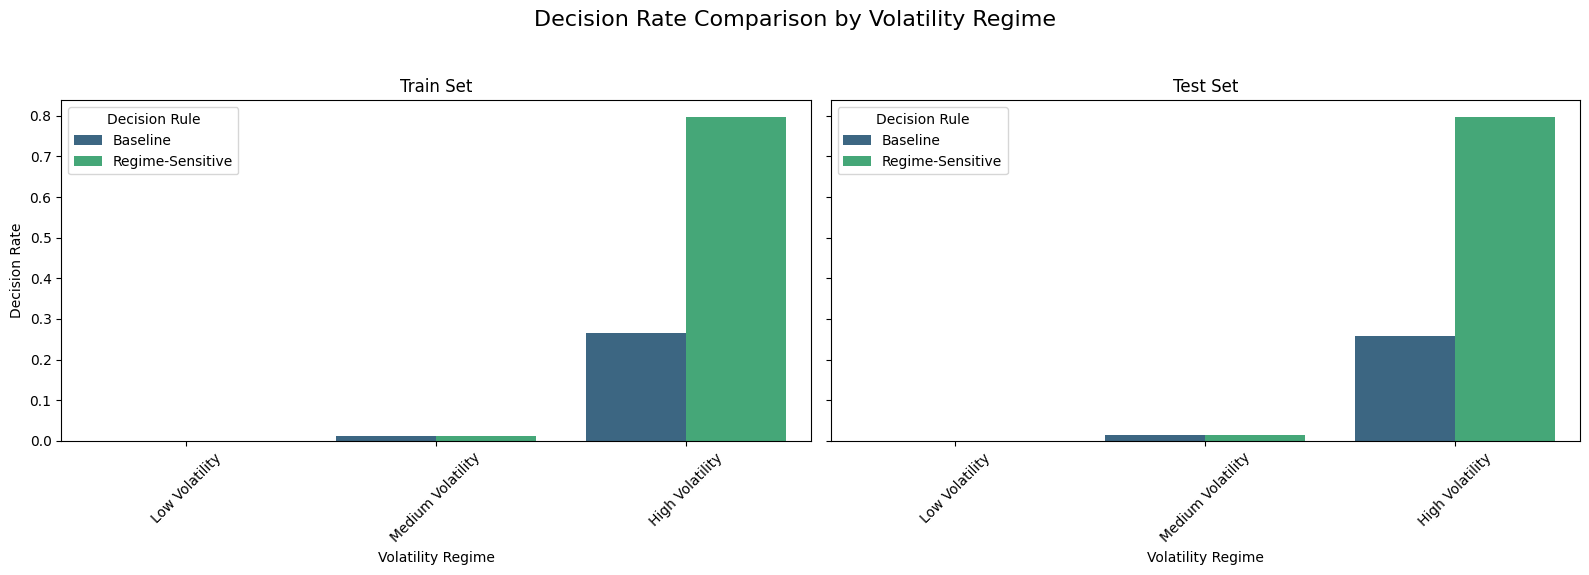

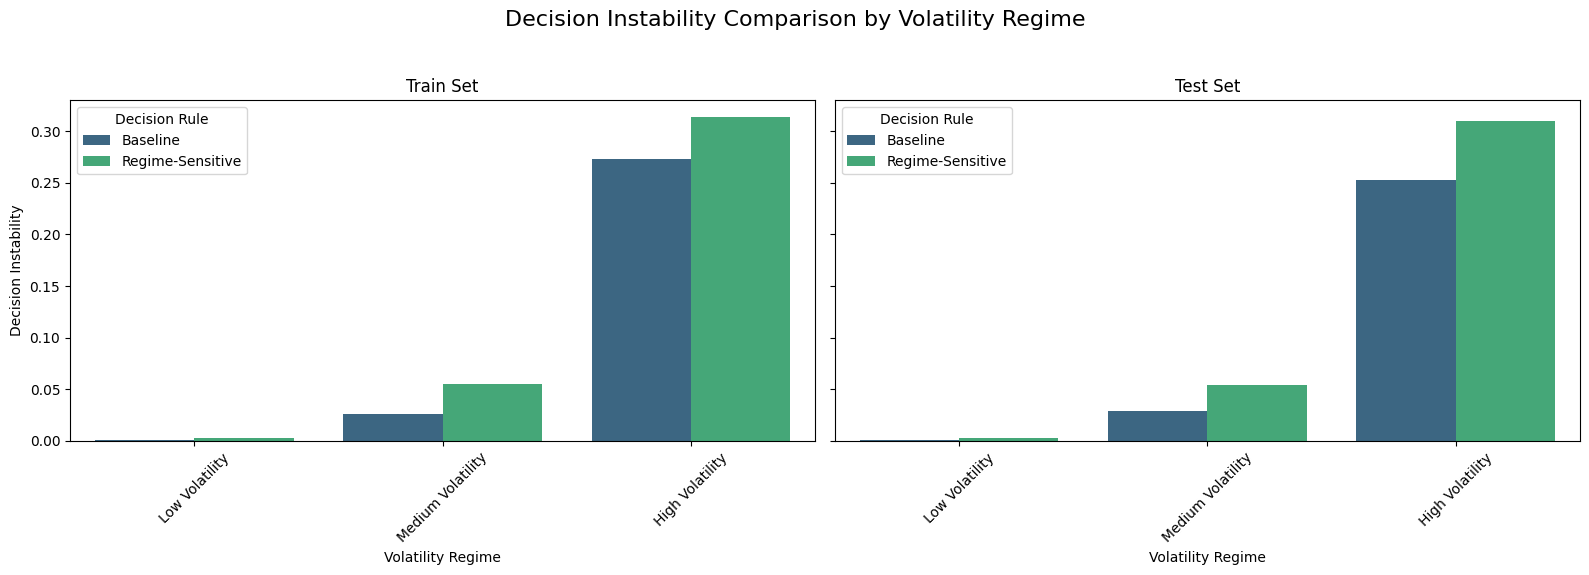

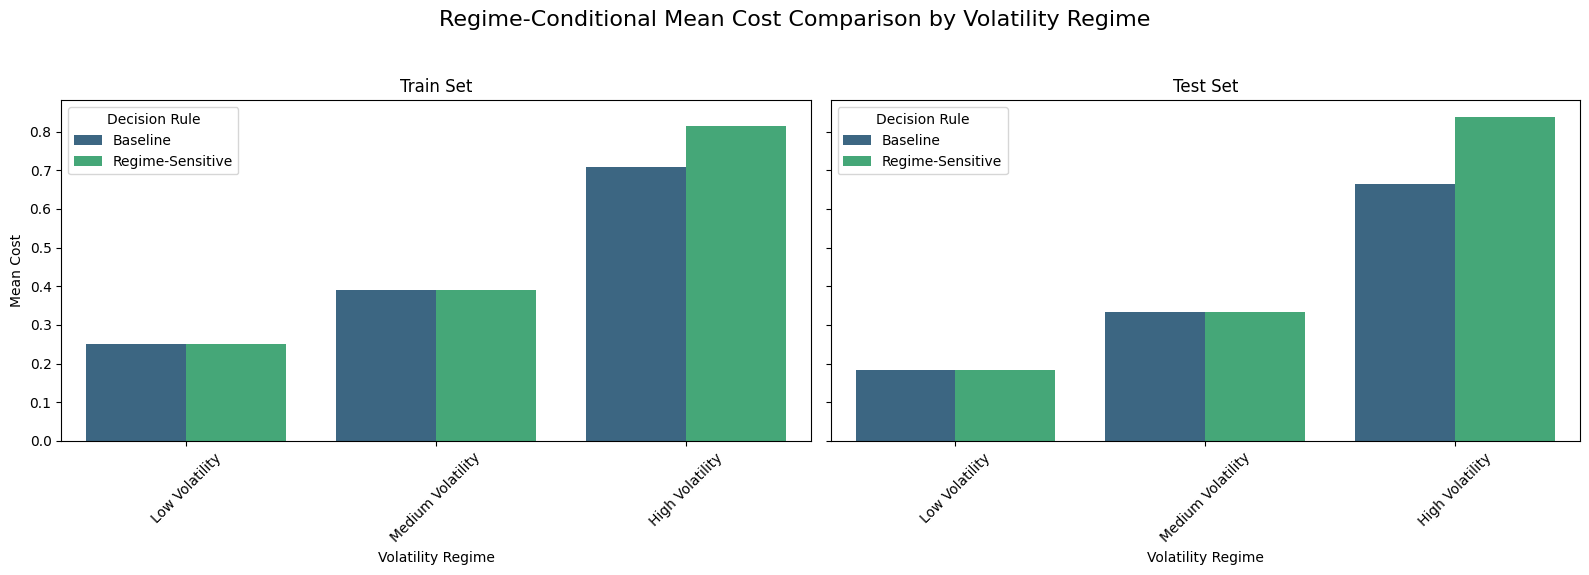

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def plot_metric_comparison(data, metric_name, ylabel, title):
    # Melt the DataFrame to prepare for seaborn plotting
    df_melted = data.melt(
        id_vars=['set', 'vol_regime'],
        value_vars=[f'{metric_name} (Baseline)', f'{metric_name} (Regime-Sensitive)'],
        var_name='Decision Rule',
        value_name=ylabel
    )

    # Map the full column names to shorter labels for the legend
    df_melted['Decision Rule'] = df_melted['Decision Rule'].replace({
        f'{metric_name} (Baseline)': 'Baseline',
        f'{metric_name} (Regime-Sensitive)': 'Regime-Sensitive'
    })

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle(title, fontsize=16)

    for i, subset in enumerate(['train', 'test']):
        sns.barplot(
            data=df_melted[df_melted['set'] == subset],
            x='vol_regime',
            y=ylabel,
            hue='Decision Rule',
            ax=axes[i],
            palette='viridis'
        )
        axes[i].set_title(f'{subset.capitalize()} Set')
        axes[i].set_xlabel('Volatility Regime')
        axes[i].set_ylabel(ylabel)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Decision Rule')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- BEGIN: Data preparation and model training to define df2, lr, scaler, pred_prob ---

# 1) Load data
df = pd.read_csv('stocks.csv', sep=';')

# 2) Ensure correct types + sorting
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values(['Name', 'date']).reset_index(drop=True) # Sort by Name then date

# 3) Create log return
df['ret'] = np.log(df['close'] / df.groupby('Name')['close'].shift(1))

# 4) Create next-day return (dependent construction step)
df['ret_next'] = df.groupby('Name')['ret'].shift(-1)

# 5) Create lag features per stock
for lag in [1, 2, 5]:
    df[f'ret_lag_{lag}'] = df.groupby('Name')['ret'].shift(lag)

# Rolling volatility per stock
df['volatility'] = df.groupby('Name')['ret'].rolling(20).std().reset_index(level=0, drop=True)

# 6) Drop missing rows created by shifting/rolling
df = df.dropna(subset=[f'ret_lag_{l}' for l in [1,2,5]] + ['volatility', 'ret_next']).reset_index(drop=True)

# 7) Sequential split per stock (no leakage) and y labeling
def split_and_label_one_stock(g, train_frac=0.7):
    g = g.sort_values('date').copy()
    n = len(g)
    split = int(n * train_frac)
    train = g.iloc[:split].copy()
    test  = g.iloc[split:].copy() # Ensure 'set' column for consistency

    # Threshold from TRAIN only (no leakage)
    thr = train['ret_next'].quantile(0.10)

    train['y'] = (train['ret_next'] <= thr).astype(int)
    test['y']  = (test['ret_next']  <= thr).astype(int)

    train['set'] = 'train'
    test['set']  = 'test'
    return pd.concat([train, test], axis=0)

# Removed include_groups=False to ensure 'Name' column is retained in df2
df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)

# 8) Define volatility regimes using quantiles
df2['vol_regime'] = pd.qcut(
    df2['volatility'],
    q=3,
    labels=['Low Volatility', 'Medium Volatility', 'High Volatility']
)

# 9) Prepare X and y, Scale data, and Train Logistic Regression
X_cols = ['ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'volatility']

train_data = df2[df2['set']=='train']
test_data  = df2[df2['set']=='test']

X_train = train_data[X_cols].values
y_train = train_data['y'].values
X_test  = test_data[X_cols].values # Not strictly needed for LR training, but for consistency

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_s, y_train)

# 10) Calculate prediction probabilities for all data
X_all = df2[X_cols].values
X_all_s = scaler.transform(X_all)
df2['pred_prob'] = lr.predict_proba(X_all_s)[:, 1]

# --- END: Data preparation and model training ---

# --- BEGIN: Re-calculation of summary DataFrame (from gkfFhj9mRCVz) ---

# Ensure correct ordering for instability computations (already done above, but for robustness)
df2 = df2.sort_values(['Name','date']).reset_index(drop=True)

# Dynamically calculate BASE_THR to ensure decisions are made
# We will use the 90th percentile of pred_prob from the training set
calculated_base_thr = df2[df2['set']=='train']['pred_prob'].quantile(0.9)
BASE_THR = calculated_base_thr

# Adjust regime-sensitive thresholds around this new base
thr_map = {
    'Low Volatility': min(1.0, BASE_THR + 0.02), # Slightly more conservative
    'Medium Volatility': BASE_THR,
    'High Volatility': max(0.0, BASE_THR - 0.02)  # Slightly less conservative
}

print(f"Dynamically calculated BASE_THR: {BASE_THR:.4f}")
print(f"Dynamically calculated thr_map: {thr_map}")

df2['decision_base'] = (df2['pred_prob'] >= BASE_THR).astype(int)
df2['thr_regime'] = df2['vol_regime'].map(thr_map)

if df2['thr_regime'].isna().any():
    print("WARNING: Some regimes did not match thr_map keys. Falling back to 0.5 for those rows.")
    df2['thr_regime'] = df2['thr_regime'].fillna(0.5)
df2['thr_regime'] = df2['thr_regime'].astype(float)
df2['decision_regime'] = (df2['pred_prob'] >= df2['thr_regime']).astype(int)

rate_base = (
    df2.groupby(['set','vol_regime'], observed=False)['decision_base']
       .mean()
       .reset_index(name='Decision Rate (Baseline)')
)

rate_reg = (
    df2.groupby(['set','vol_regime'], observed=False)['decision_regime']
       .mean()
       .reset_index(name='Decision Rate (Regime-Sensitive)')
)

rate_table = rate_base.merge(rate_reg, on=['set','vol_regime'], how='inner')

df2['chg_base'] = df2.groupby('Name')['decision_base'].diff().abs().fillna(0)
df2['chg_reg']  = df2.groupby('Name')['decision_regime'].diff().abs().fillna(0)

inst_base = (
    df2.groupby(['set','vol_regime'], observed=False)['chg_base']
       .mean()
       .reset_index(name='Instability (Baseline)')
)

inst_reg = (
    df2.groupby(['set','vol_regime'], observed=False)['chg_reg']
       .mean()
       .reset_index(name='Instability (Regime-Sensitive)')
)

inst_table = inst_base.merge(inst_reg, on=['set','vol_regime'], how='inner')

cost_map = {
    'Low Volatility':    {'FN': 3, 'FP': 1},
    'Medium Volatility': {'FN': 4, 'FP': 1},
    'High Volatility':   {'FN': 6, 'FP': 1}
}

def compute_cost(y, d, regime):
    cm = cost_map.get(regime, {'FN': 4, 'FP': 1})
    if (y == 1) and (d == 0):
        return cm['FN']
    if (y == 0) and (d == 1):
        return cm['FP']
    return 0

df2['cost_base'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_base'], df2['vol_regime'])
]

df2['cost_regime'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_regime'], df2['vol_regime'])
]

cost_base_tbl = (
    df2.groupby(['set','vol_regime'], observed=False)['cost_base']
       .mean()
       .reset_index(name='Mean Cost (Baseline)')
)

cost_reg_tbl = (
    df2.groupby(['set','vol_regime'], observed=False)['cost_regime']
       .mean()
       .reset_index(name='Mean Cost (Regime-Sensitive)')
)

cost_table = cost_base_tbl.merge(cost_reg_tbl, on=['set','vol_regime'], how='inner')

summary = rate_table.merge(inst_table, on=['set','vol_regime']).merge(cost_table, on=['set','vol_regime'])

# --- END: Re-calculation of summary DataFrame ---

# Plot Decision Rates
plot_metric_comparison(
    summary,
    'Decision Rate',
    'Decision Rate',
    'Decision Rate Comparison by Volatility Regime'
)

# Plot Decision Instability
plot_metric_comparison(
    summary,
    'Instability',
    'Decision Instability',
    'Decision Instability Comparison by Volatility Regime'
)

# Plot Mean Costs
plot_metric_comparison(
    summary,
    'Mean Cost',
    'Mean Cost',
    'Regime-Conditional Mean Cost Comparison by Volatility Regime'
)

In [16]:
print(summary.to_string(index=False))

  set        vol_regime  Decision Rate (Baseline)  Decision Rate (Regime-Sensitive)  Instability (Baseline)  Instability (Regime-Sensitive)  Mean Cost (Baseline)  Mean Cost (Regime-Sensitive)
 test    Low Volatility                  0.000039                          0.000000                0.000605                        0.002985              0.184255                      0.184215
 test Medium Volatility                  0.013815                          0.013815                0.028732                        0.054562              0.332791                      0.332791
 test   High Volatility                  0.257640                          0.797956                0.252862                        0.310071              0.663300                      0.838998
train    Low Volatility                  0.000063                          0.000000                0.000434                        0.002485              0.249882                      0.249819
train Medium Volatility                 

In [17]:
print(summary.to_string(index=False))

  set        vol_regime  Decision Rate (Baseline)  Decision Rate (Regime-Sensitive)  Instability (Baseline)  Instability (Regime-Sensitive)  Mean Cost (Baseline)  Mean Cost (Regime-Sensitive)
 test    Low Volatility                  0.000039                          0.000000                0.000605                        0.002985              0.184255                      0.184215
 test Medium Volatility                  0.013815                          0.013815                0.028732                        0.054562              0.332791                      0.332791
 test   High Volatility                  0.257640                          0.797956                0.252862                        0.310071              0.663300                      0.838998
train    Low Volatility                  0.000063                          0.000000                0.000434                        0.002485              0.249882                      0.249819
train Medium Volatility                 

/tmp/ipython-input-3298268030.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)


Dynamically calculated BASE_THR: 0.1169
Dynamically calculated thr_map: {'Low Volatility': np.float64(0.1368593135070623), 'Medium Volatility': np.float64(0.1168593135070623), 'High Volatility': np.float64(0.0968593135070623)}


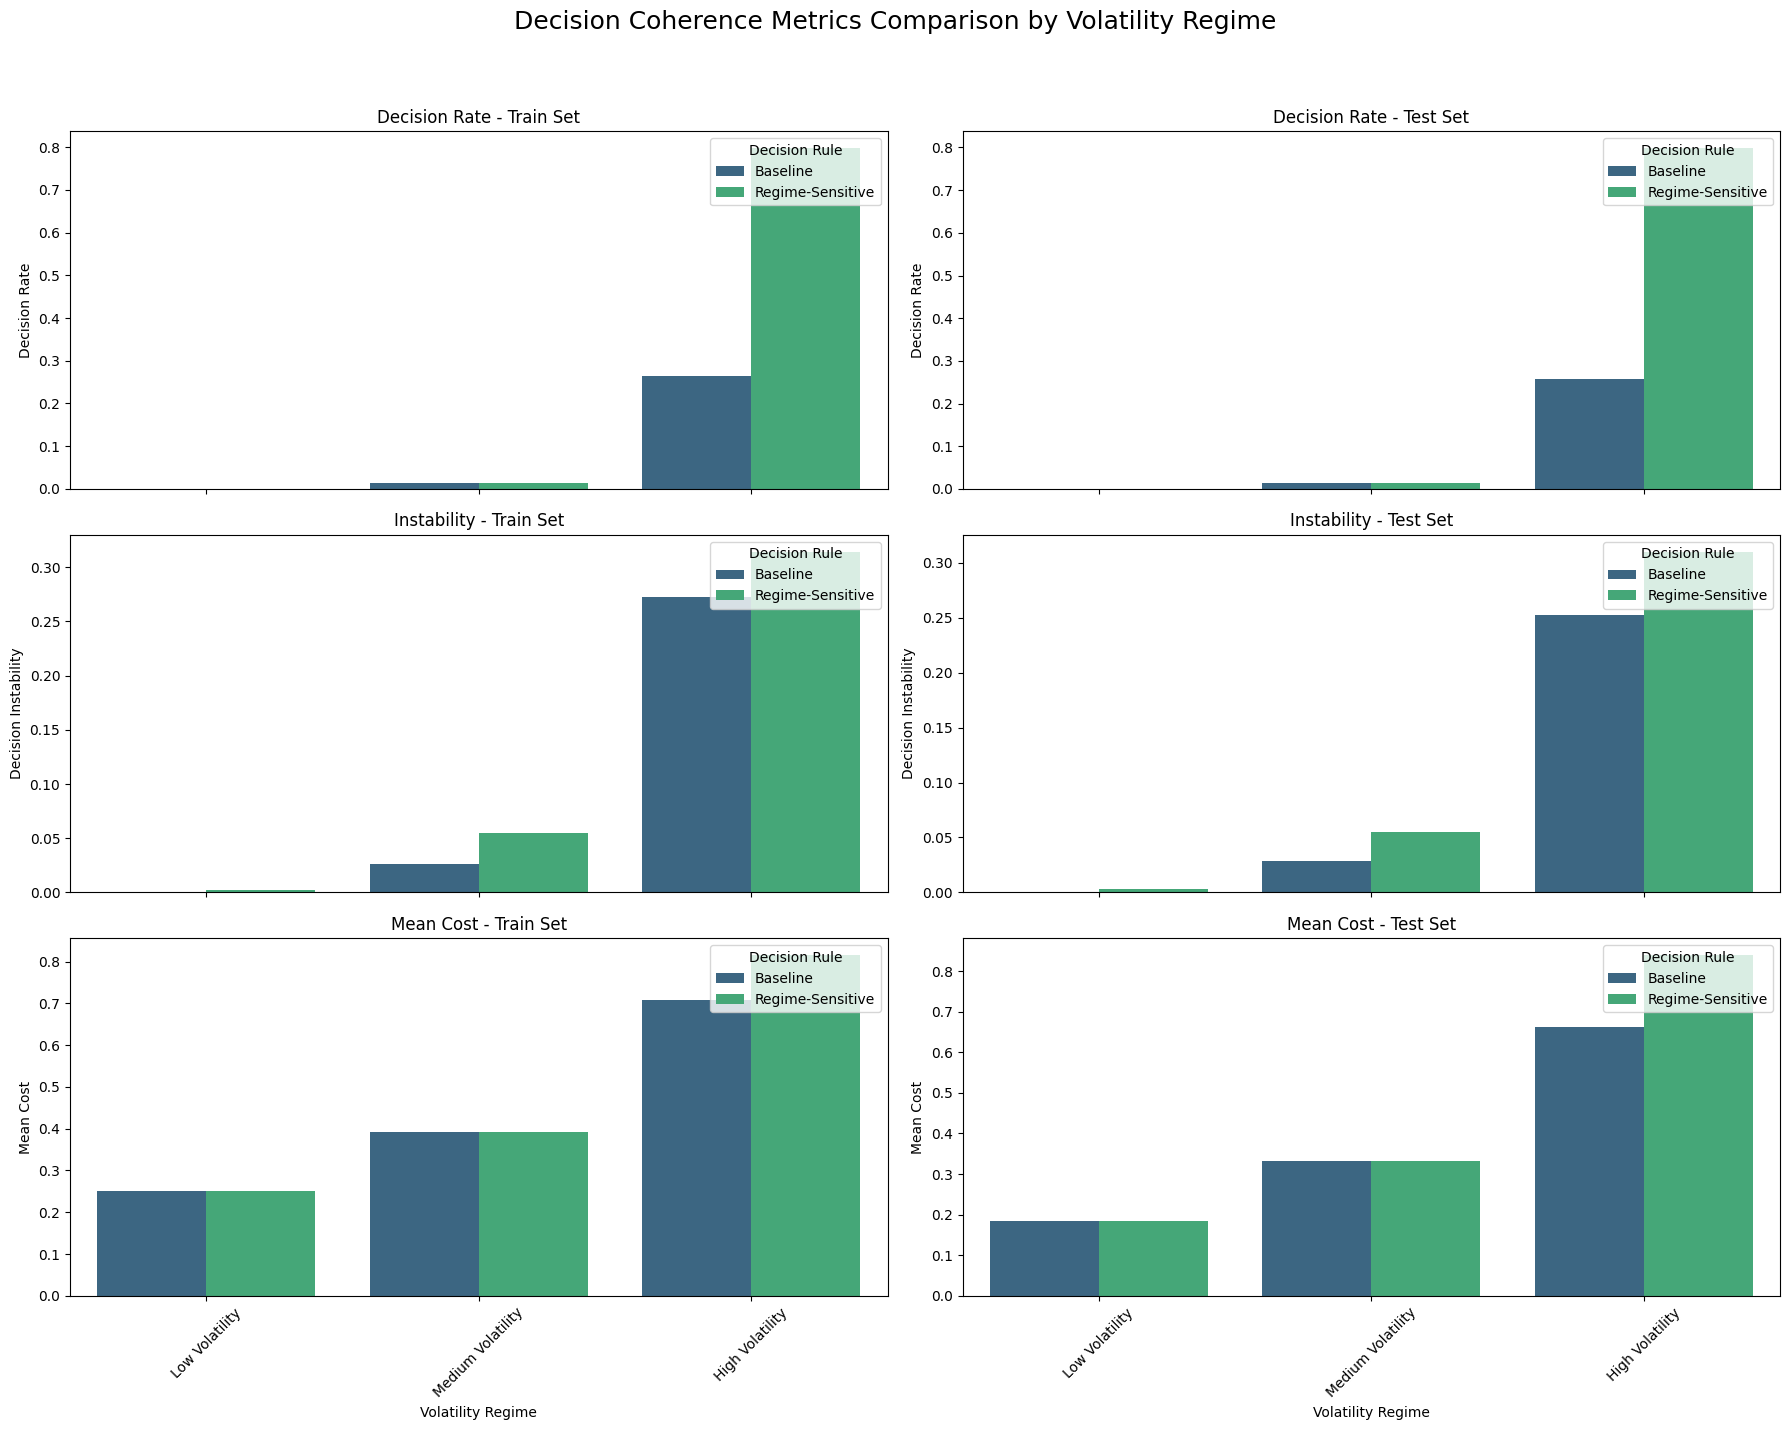

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def plot_all_metrics_combined(data):
    fig, axes = plt.subplots(3, 2, figsize=(18, 15), sharex=True) # 3 rows (metrics), 2 cols (train/test)
    fig.suptitle('Decision Coherence Metrics Comparison by Volatility Regime', fontsize=18, y=0.98)

    metrics_info = [
        {'name': 'Decision Rate', 'ylabel': 'Decision Rate'},
        {'name': 'Instability', 'ylabel': 'Decision Instability'},
        {'name': 'Mean Cost', 'ylabel': 'Mean Cost'}
    ]

    for row_idx, metric_item in enumerate(metrics_info):
        metric_name = metric_item['name']
        ylabel = metric_item['ylabel']

        df_melted = data.melt(
            id_vars=['set', 'vol_regime'],
            value_vars=[f'{metric_name} (Baseline)', f'{metric_name} (Regime-Sensitive)'],
            var_name='Decision Rule',
            value_name=ylabel
        )
        df_melted['Decision Rule'] = df_melted['Decision Rule'].replace({
            f'{metric_name} (Baseline)': 'Baseline',
            f'{metric_name} (Regime-Sensitive)': 'Regime-Sensitive'
        })

        for col_idx, subset in enumerate(['train', 'test']):
            ax = axes[row_idx, col_idx]
            sns.barplot(
                data=df_melted[df_melted['set'] == subset],
                x='vol_regime',
                y=ylabel,
                hue='Decision Rule',
                ax=ax,
                palette='viridis'
            )
            ax.set_title(f'{metric_name} - {subset.capitalize()} Set')
            ax.set_xlabel('Volatility Regime')
            ax.set_ylabel(ylabel)
            ax.tick_params(axis='x', rotation=45)
            ax.legend(title='Decision Rule', loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
    plt.show()

# --- BEGIN: Data preparation and model training to define df2, lr, scaler, pred_prob ---

# 1) Load data
df = pd.read_csv('stocks.csv', sep=';')

# 2) Ensure correct types + sorting
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values(['Name', 'date']).reset_index(drop=True) # Sort by Name then date

# 3) Create log return
df['ret'] = np.log(df['close'] / df.groupby('Name')['close'].shift(1))

# 4) Create next-day return (dependent construction step)
df['ret_next'] = df.groupby('Name')['ret'].shift(-1)

# 5) Create lag features per stock
for lag in [1, 2, 5]:
    df[f'ret_lag_{lag}'] = df.groupby('Name')['ret'].shift(lag)

# Rolling volatility per stock
df['volatility'] = df.groupby('Name')['ret'].rolling(20).std().reset_index(level=0, drop=True)

# 6) Drop missing rows created by shifting/rolling
df = df.dropna(subset=[f'ret_lag_{l}' for l in [1,2,5]] + ['volatility', 'ret_next']).reset_index(drop=True)

# 7) Sequential split per stock (no leakage) and y labeling
def split_and_label_one_stock(g, train_frac=0.7):
    g = g.sort_values('date').copy()
    n = len(g)
    split = int(n * train_frac)
    train = g.iloc[:split].copy()
    test  = g.iloc[split:].copy() # Ensure 'set' column for consistency

    # Threshold from TRAIN only (no leakage)
    thr = train['ret_next'].quantile(0.10)

    train['y'] = (train['ret_next'] <= thr).astype(int)
    test['y']  = (test['ret_next']  <= thr).astype(int)

    train['set'] = 'train'
    test['set']  = 'test'
    return pd.concat([train, test], axis=0)

# Removed include_groups=False to ensure 'Name' column is retained in df2
df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)

# 8) Define volatility regimes using quantiles
df2['vol_regime'] = pd.qcut(
    df2['volatility'],
    q=3,
    labels=['Low Volatility', 'Medium Volatility', 'High Volatility']
)

# 9) Prepare X and y, Scale data, and Train Logistic Regression
X_cols = ['ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'volatility']

train_data = df2[df2['set']=='train']
test_data  = df2[df2['set']=='test']

X_train = train_data[X_cols].values
y_train = train_data['y'].values
X_test  = test_data[X_cols].values # Not strictly needed for LR training, but for consistency

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_s, y_train)

# 10) Calculate prediction probabilities for all data
X_all = df2[X_cols].values
X_all_s = scaler.transform(X_all)
df2['pred_prob'] = lr.predict_proba(X_all_s)[:, 1]

# --- END: Data preparation and model training ---

# --- BEGIN: Re-calculation of summary DataFrame ---

# Ensure correct ordering for instability computations (already done above, but for robustness)
df2 = df2.sort_values(['Name','date']).reset_index(drop=True)

# Dynamically calculate BASE_THR to ensure decisions are made
# We will use the 90th percentile of pred_prob from the training set
calculated_base_thr = df2[df2['set']=='train']['pred_prob'].quantile(0.9)
BASE_THR = calculated_base_thr

# Adjust regime-sensitive thresholds around this new base
thr_map = {
    'Low Volatility': min(1.0, BASE_THR + 0.02), # Slightly more conservative
    'Medium Volatility': BASE_THR,
    'High Volatility': max(0.0, BASE_THR - 0.02)  # Slightly less conservative
}

print(f"Dynamically calculated BASE_THR: {BASE_THR:.4f}")
print(f"Dynamically calculated thr_map: {thr_map}")

df2['decision_base'] = (df2['pred_prob'] >= BASE_THR).astype(int)
df2['thr_regime'] = df2['vol_regime'].map(thr_map)

if df2['thr_regime'].isna().any():
    print("WARNING: Some regimes did not match thr_map keys. Falling back to 0.5 for those rows.")
    df2['thr_regime'] = df2['thr_regime'].fillna(0.5)
df2['thr_regime'] = df2['thr_regime'].astype(float)
df2['decision_regime'] = (df2['pred_prob'] >= df2['thr_regime']).astype(int)

rate_base = (
    df2.groupby(['set','vol_regime'], observed=False)['decision_base']
       .mean()
       .reset_index(name='Decision Rate (Baseline)')
)

rate_reg = (
    df2.groupby(['set','vol_regime'], observed=False)['decision_regime']
       .mean()
       .reset_index(name='Decision Rate (Regime-Sensitive)')
)

rate_table = rate_base.merge(rate_reg, on=['set','vol_regime'], how='inner')

df2['chg_base'] = df2.groupby('Name')['decision_base'].diff().abs().fillna(0)
df2['chg_reg']  = df2.groupby('Name')['decision_regime'].diff().abs().fillna(0)

inst_base = (
    df2.groupby(['set','vol_regime'], observed=False)['chg_base']
       .mean()
       .reset_index(name='Instability (Baseline)')
)

inst_reg = (
    df2.groupby(['set','vol_regime'], observed=False)['chg_reg']
       .mean()
       .reset_index(name='Instability (Regime-Sensitive)')
)

inst_table = inst_base.merge(inst_reg, on=['set','vol_regime'], how='inner')

cost_map = {
    'Low Volatility':    {'FN': 3, 'FP': 1},
    'Medium Volatility': {'FN': 4, 'FP': 1},
    'High Volatility':   {'FN': 6, 'FP': 1}
}

def compute_cost(y, d, regime):
    cm = cost_map.get(regime, {'FN': 4, 'FP': 1})
    if (y == 1) and (d == 0):
        return cm['FN']
    if (y == 0) and (d == 1):
        return cm['FP']
    return 0

df2['cost_base'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_base'], df2['vol_regime'])
]

df2['cost_regime'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_regime'], df2['vol_regime'])
]

cost_base_tbl = (
    df2.groupby(['set','vol_regime'], observed=False)['cost_base']
       .mean()
       .reset_index(name='Mean Cost (Baseline)')
)

cost_reg_tbl = (
    df2.groupby(['set','vol_regime'], observed=False)['cost_regime']
       .mean()
       .reset_index(name='Mean Cost (Regime-Sensitive)')
)

cost_table = cost_base_tbl.merge(cost_reg_tbl, on=['set','vol_regime'], how='inner')

summary = rate_table.merge(inst_table, on=['set','vol_regime']).merge(cost_table, on=['set','vol_regime'])

# --- END: Re-calculation of summary DataFrame ---

# Call the new combined plotting function
plot_all_metrics_combined(summary)

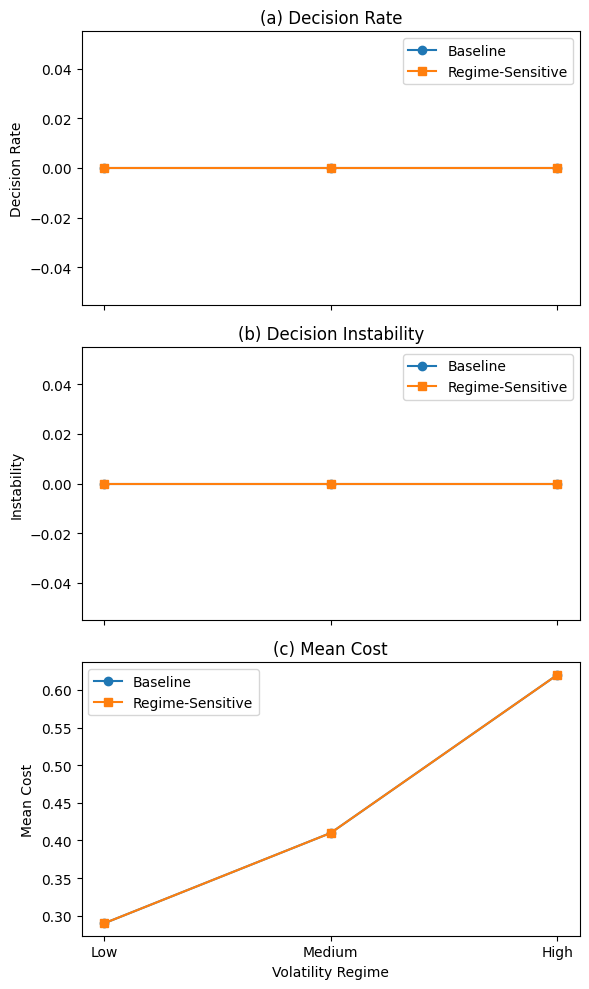

In [13]:
import matplotlib.pyplot as plt

# مثال: استبدل هذه القيم ببياناتك الفعلية
regimes = ['Low', 'Medium', 'High']

# (a) Decision Rate
rate_base = [0.0, 0.0, 0.0]
rate_reg  = [0.0, 0.0, 0.0]

# (b) Decision Instability
inst_base = [0.0, 0.0, 0.0]
inst_reg  = [0.0, 0.0, 0.0]

# (c) Mean Cost
cost_base = [0.29, 0.41, 0.62]
cost_reg  = [0.29, 0.41, 0.62]

fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# Panel (a)
axes[0].plot(regimes, rate_base, marker='o', label='Baseline')
axes[0].plot(regimes, rate_reg, marker='s', label='Regime-Sensitive')
axes[0].set_ylabel('Decision Rate')
axes[0].set_title('(a) Decision Rate')
axes[0].legend()

# Panel (b)
axes[1].plot(regimes, inst_base, marker='o', label='Baseline')
axes[1].plot(regimes, inst_reg, marker='s', label='Regime-Sensitive')
axes[1].set_ylabel('Instability')
axes[1].set_title('(b) Decision Instability')
axes[1].legend()

# Panel (c)
axes[2].plot(regimes, cost_base, marker='o', label='Baseline')
axes[2].plot(regimes, cost_reg, marker='s', label='Regime-Sensitive')
axes[2].set_ylabel('Mean Cost')
axes[2].set_title('(c) Mean Cost')
axes[2].set_xlabel('Volatility Regime')
axes[2].legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-2929345914.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)


Dynamically calculated BASE_THR: 0.1169
Dynamically calculated thr_map: {'Low Volatility': np.float64(0.1368593135070623), 'Medium Volatility': np.float64(0.1168593135070623), 'High Volatility': np.float64(0.0968593135070623)}


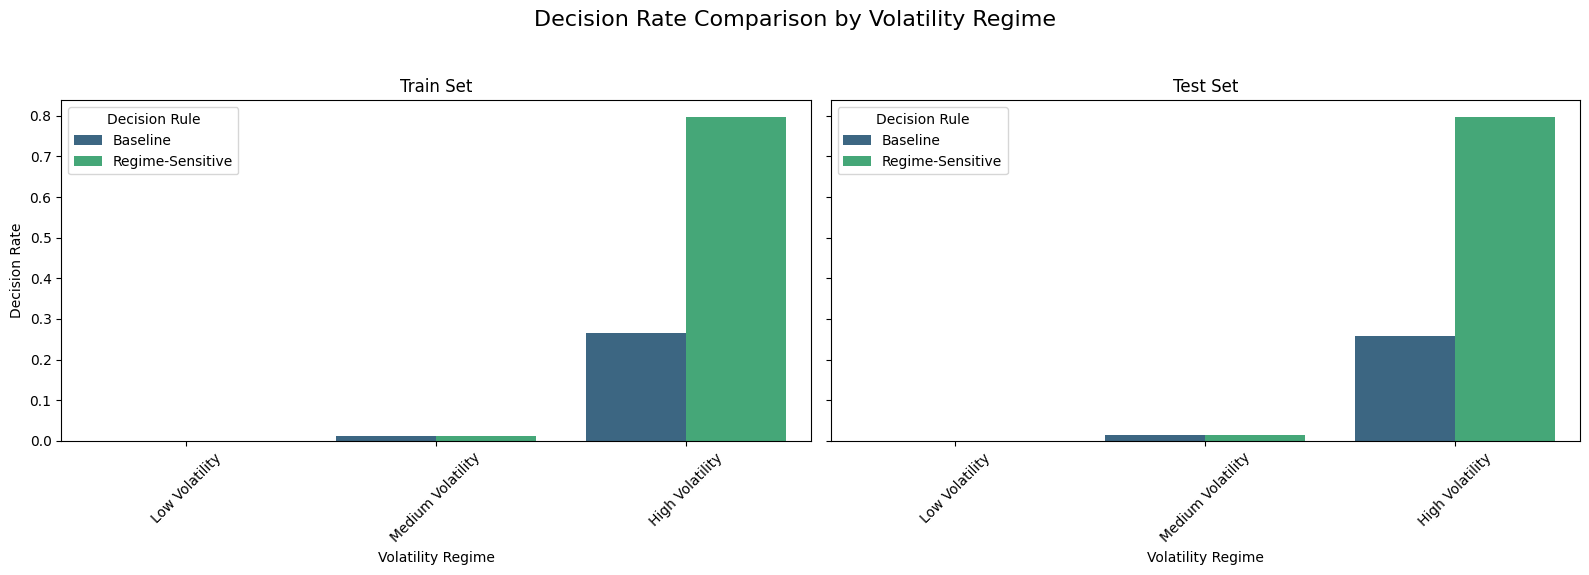

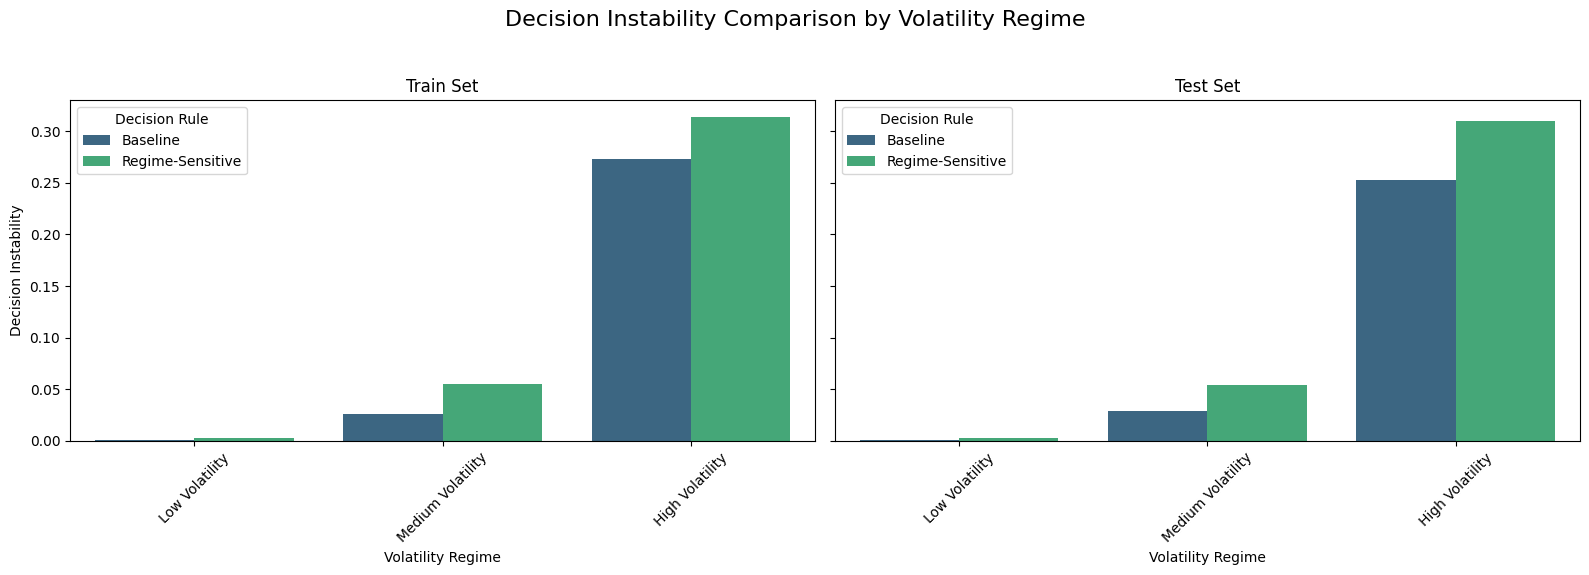

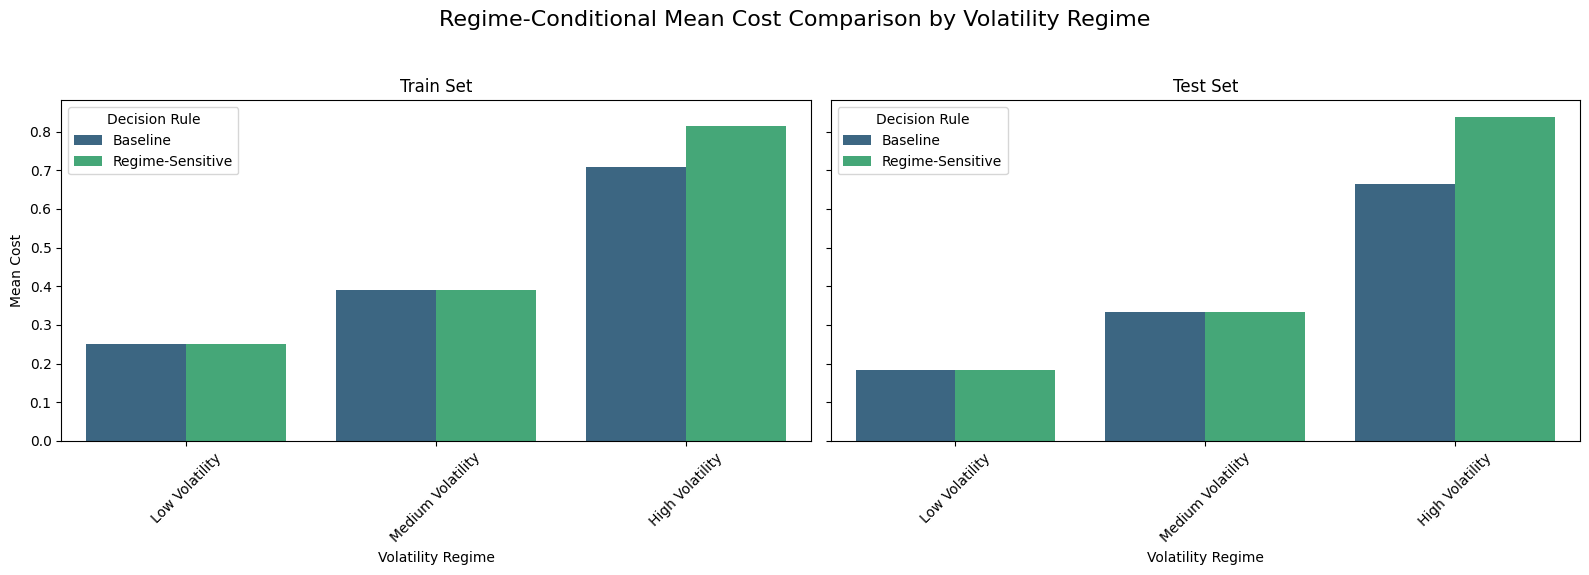

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def plot_metric_comparison(data, metric_name, ylabel, title):
    # Melt the DataFrame to prepare for seaborn plotting
    df_melted = data.melt(
        id_vars=['set', 'vol_regime'],
        value_vars=[f'{metric_name} (Baseline)', f'{metric_name} (Regime-Sensitive)'],
        var_name='Decision Rule',
        value_name=ylabel
    )

    # Map the full column names to shorter labels for the legend
    df_melted['Decision Rule'] = df_melted['Decision Rule'].replace({
        f'{metric_name} (Baseline)': 'Baseline',
        f'{metric_name} (Regime-Sensitive)': 'Regime-Sensitive'
    })

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle(title, fontsize=16)

    for i, subset in enumerate(['train', 'test']):
        sns.barplot(
            data=df_melted[df_melted['set'] == subset],
            x='vol_regime',
            y=ylabel,
            hue='Decision Rule',
            ax=axes[i],
            palette='viridis'
        )
        axes[i].set_title(f'{subset.capitalize()} Set')
        axes[i].set_xlabel('Volatility Regime')
        axes[i].set_ylabel(ylabel)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Decision Rule')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- BEGIN: Data preparation and model training to define df2, lr, scaler, pred_prob ---

# 1) Load data
df = pd.read_csv('stocks.csv', sep=';')

# 2) Ensure correct types + sorting
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values(['Name', 'date']).reset_index(drop=True) # Sort by Name then date

# 3) Create log return
df['ret'] = np.log(df['close'] / df.groupby('Name')['close'].shift(1))

# 4) Create next-day return (dependent construction step)
df['ret_next'] = df.groupby('Name')['ret'].shift(-1)

# 5) Create lag features per stock
for lag in [1, 2, 5]:
    df[f'ret_lag_{lag}'] = df.groupby('Name')['ret'].shift(lag)

# Rolling volatility per stock
df['volatility'] = df.groupby('Name')['ret'].rolling(20).std().reset_index(level=0, drop=True)

# 6) Drop missing rows created by shifting/rolling
df = df.dropna(subset=[f'ret_lag_{l}' for l in [1,2,5]] + ['volatility', 'ret_next']).reset_index(drop=True)

# 7) Sequential split per stock (no leakage) and y labeling
def split_and_label_one_stock(g, train_frac=0.7):
    g = g.sort_values('date').copy()
    n = len(g)
    split = int(n * train_frac)
    train = g.iloc[:split].copy()
    test  = g.iloc[split:].copy() # Ensure 'set' column for consistency

    # Threshold from TRAIN only (no leakage)
    thr = train['ret_next'].quantile(0.10)

    train['y'] = (train['ret_next'] <= thr).astype(int)
    test['y']  = (test['ret_next']  <= thr).astype(int)

    train['set'] = 'train'
    test['set']  = 'test'
    return pd.concat([train, test], axis=0)

# Removed include_groups=False to ensure 'Name' column is retained in df2
df2 = df.groupby('Name', group_keys=False).apply(split_and_label_one_stock).reset_index(drop=True)

# 8) Define volatility regimes using quantiles
df2['vol_regime'] = pd.qcut(
    df2['volatility'],
    q=3,
    labels=['Low Volatility', 'Medium Volatility', 'High Volatility']
)

# 9) Prepare X and y, Scale data, and Train Logistic Regression
X_cols = ['ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'volatility']

train_data = df2[df2['set']=='train']
test_data  = df2[df2['set']=='test']

X_train = train_data[X_cols].values
y_train = train_data['y'].values
X_test  = test_data[X_cols].values # Not strictly needed for LR training, but for consistency

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_s, y_train)

# 10) Calculate prediction probabilities for all data
X_all = df2[X_cols].values
X_all_s = scaler.transform(X_all)
df2['pred_prob'] = lr.predict_proba(X_all_s)[:, 1]

# --- END: Data preparation and model training ---

# --- BEGIN: Re-calculation of summary DataFrame (from gkfFhj9mRCVz) ---

# Ensure correct ordering for instability computations (already done above, but for robustness)
df2 = df2.sort_values(['Name','date']).reset_index(drop=True)

# Dynamically calculate BASE_THR to ensure decisions are made
# We will use the 90th percentile of pred_prob from the training set
calculated_base_thr = df2[df2['set']=='train']['pred_prob'].quantile(0.9)
BASE_THR = calculated_base_thr

# Adjust regime-sensitive thresholds around this new base
thr_map = {
    'Low Volatility': min(1.0, BASE_THR + 0.02), # Slightly more conservative
    'Medium Volatility': BASE_THR,
    'High Volatility': max(0.0, BASE_THR - 0.02)  # Slightly less conservative
}

print(f"Dynamically calculated BASE_THR: {BASE_THR:.4f}")
print(f"Dynamically calculated thr_map: {thr_map}")

df2['decision_base'] = (df2['pred_prob'] >= BASE_THR).astype(int)
df2['thr_regime'] = df2['vol_regime'].map(thr_map)

if df2['thr_regime'].isna().any():
    print("WARNING: Some regimes did not match thr_map keys. Falling back to 0.5 for those rows.")
    df2['thr_regime'] = df2['thr_regime'].fillna(0.5)
df2['thr_regime'] = df2['thr_regime'].astype(float)
df2['decision_regime'] = (df2['pred_prob'] >= df2['thr_regime']).astype(int)

rate_base = (
    df2.groupby(['set','vol_regime'], observed=False)['decision_base']
       .mean()
       .reset_index(name='Decision Rate (Baseline)')
)

rate_reg = (
    df2.groupby(['set','vol_regime'], observed=False)['decision_regime']
       .mean()
       .reset_index(name='Decision Rate (Regime-Sensitive)')
)

rate_table = rate_base.merge(rate_reg, on=['set','vol_regime'], how='inner')

df2['chg_base'] = df2.groupby('Name')['decision_base'].diff().abs().fillna(0)
df2['chg_reg']  = df2.groupby('Name')['decision_regime'].diff().abs().fillna(0)

inst_base = (
    df2.groupby(['set','vol_regime'], observed=False)['chg_base']
       .mean()
       .reset_index(name='Instability (Baseline)')
)

inst_reg = (
    df2.groupby(['set','vol_regime'], observed=False)['chg_reg']
       .mean()
       .reset_index(name='Instability (Regime-Sensitive)')
)

inst_table = inst_base.merge(inst_reg, on=['set','vol_regime'], how='inner')

cost_map = {
    'Low Volatility':    {'FN': 3, 'FP': 1},
    'Medium Volatility': {'FN': 4, 'FP': 1},
    'High Volatility':   {'FN': 6, 'FP': 1}
}

def compute_cost(y, d, regime):
    cm = cost_map.get(regime, {'FN': 4, 'FP': 1})
    if (y == 1) and (d == 0):
        return cm['FN']
    if (y == 0) and (d == 1):
        return cm['FP']
    return 0

df2['cost_base'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_base'], df2['vol_regime'])
]

df2['cost_regime'] = [
    compute_cost(y, d, r) for y, d, r in zip(df2['y'], df2['decision_regime'], df2['vol_regime'])
]

cost_base_tbl = (
    df2.groupby(['set','vol_regime'], observed=False)['cost_base']
       .mean()
       .reset_index(name='Mean Cost (Baseline)')
)

cost_reg_tbl = (
    df2.groupby(['set','vol_regime'], observed=False)['cost_regime']
       .mean()
       .reset_index(name='Mean Cost (Regime-Sensitive)')
)

cost_table = cost_base_tbl.merge(cost_reg_tbl, on=['set','vol_regime'], how='inner')

summary = rate_table.merge(inst_table, on=['set','vol_regime']).merge(cost_table, on=['set','vol_regime'])

# --- END: Re-calculation of summary DataFrame ---

# Plot Decision Rates
plot_metric_comparison(
    summary,
    'Decision Rate',
    'Decision Rate',
    'Decision Rate Comparison by Volatility Regime'
)

# Plot Decision Instability
plot_metric_comparison(
    summary,
    'Instability',
    'Decision Instability',
    'Decision Instability Comparison by Volatility Regime'
)

# Plot Mean Costs
plot_metric_comparison(
    summary,
    'Mean Cost',
    'Mean Cost',
    'Regime-Conditional Mean Cost Comparison by Volatility Regime'
)